
# Integrated SPEC2SMILES Pipeline
## End-to-End Molecular Identification from Mass Spectra

### Abstract
This notebook implements the complete integrated pipeline for molecular structure elucidation from mass spectral data. The system cascades gradient boosting-based descriptor prediction (Component A) with conditional variational autoencoder-based structure generation (Component B) to achieve end-to-end molecular identification.

### System Architecture

```mermaid
flowchart TB
    subgraph Input
        MS["Mass Spectrum<br/>x ∈ [0,1]^500"]
    end
    
    subgraph Component A
        MS --> GB["Gradient Boosting<br/>Ensemble (12 models)"]
        GB --> D["Descriptors<br/>d ∈ R^12"]
    end
    
    subgraph Component B
        D --> Scale["StandardScaler"]
        Scale --> Prior["p(z|d)"]
        Prior --> Sample["Sample z₁...z_n"]
        Sample --> CVAE["Conditional VAE<br/>Decoder"]
        CVAE --> SELF["SELFIES<br/>Candidates"]
        SELF --> SMILES["SMILES<br/>Structures"]
    end
    
    subgraph Output
        SMILES --> Rank["Rank by<br/>Similarity"]
        Rank --> Result["Top-K<br/>Candidates"]
    end
```

### Mathematical Formulation

#### Full Pipeline
The integrated system implements the composition:

$$\mathcal{F}: \mathbb{R}^{500} \xrightarrow{f_A} \mathbb{R}^{12} \xrightarrow{f_B} \Sigma^* \xrightarrow{decode} \mathcal{M}$$

where:
- $f_A$: Spectrum → Descriptors (LightGBM ensemble)
- $f_B$: Descriptors → SELFIES (Conditional VAE)
- $\mathcal{M}$: Space of valid molecules

#### Uncertainty Propagation
Prediction uncertainty flows through the pipeline:

$$\text{Var}[\mathcal{F}(x)] = \text{Var}[f_B(f_A(x))] \approx \text{Var}[f_B|f_A(x)] + J_{f_B}^T \text{Var}[f_A(x)] J_{f_B}$$

where $J_{f_B}$ is the Jacobian of the generation function.

## Pipeline Configuration

### Integrated System Parameters

```mermaid
flowchart TB
    Config["Master Config"]
    
    Config --> CA["Component A"]
    Config --> CB["Component B"]
    Config --> Inf["Inference"]
    Config --> Eval["Evaluation"]
    
    CA --> LGB["LightGBM Settings"]
    CB --> CVAE["CVAE Settings"]
    Inf --> Samp["n_candidates: 50"]
    Inf --> Temp["temperature: 0.7"]
    Inf --> TopP["top_p: 0.9"]
```

### Inference Configuration
- **Candidates per Spectrum**: 50 (balance quality/speed)
- **Sampling Temperature**: 0.7 (controlled diversity)
- **Nucleus Sampling**: top_p = 0.9 (quality filtering)
- **Batch Size**: 32 (memory optimization)

In [1]:
# Configuration
CONFIG = {
    'dataset': 'hpj',  # Dataset identifier
    'mode': 'identify',  # Molecular identification mode
    'pipeline': 'spectra_to_smiles',
    
    # Model paths
    'models': {
        'part_a': '../data/models/part_a',  # LightGBM models directory
        'part_b': '../data/models/part_b'   # CVAE model directory
    },
    
    # Inference parameters
    'inference': {
        'n_candidates': 50,  # Number of structure candidates
        'temperature': 0.7,  # Sampling temperature
        'top_p': 0.9,        # Nucleus sampling threshold
        'batch_size': 32     # Inference batch size
    },
    
    # Evaluation parameters
    'evaluation': {
        'n_test_samples': 500,  # Number of test molecules
        'hit_k': [1, 5, 10, 20, 50],  # K values for Hit@K metric
        'save_results': True
    },
    
    # Data paths
    'paths': {
        'data_dir': '../data/processed',
        'results_dir': '../data/results/integration'
    }
}

print("Integrated Pipeline Configuration")
print(f"Dataset: {CONFIG['dataset']}")
print(f"Mode: {CONFIG['mode'].upper()}")
print(f"Pipeline: {CONFIG['pipeline']}")
print(f"Candidates per spectrum: {CONFIG['inference']['n_candidates']}")

Integrated Pipeline Configuration
Dataset: hpj
Mode: IDENTIFY
Pipeline: spectra_to_smiles
Candidates per spectrum: 50


In [2]:
# Import dependencies
import json
import pickle
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import time
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, DataStructs
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# SELFIES
import selfies as sf

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Create output directory
results_dir = Path(CONFIG['paths']['results_dir']) / CONFIG['dataset']
results_dir.mkdir(parents=True, exist_ok=True)
print(f"Results directory: {results_dir}")

Computation device: cuda
Results directory: ..\data\results\integration\hpj


## 1. Component Model Loading

### Model Artifact Management

```mermaid
flowchart TD
    subgraph Component A Artifacts
        A1["12 LightGBM Models"]
        A2["Feature Names"]
        A3["Preprocessing Config"]
        A4["Performance Metrics"]
    end
    
    subgraph Component B Artifacts
        B1["CVAE State Dict"]
        B2["Vocabulary"]
        B3["Descriptor Scaler"]
        B4["Model Config"]
    end
    
    A1 --> Load["Model Loader"]
    B1 --> Load
    Load --> Valid["Compatibility Check"]
    Valid --> Ready["Pipeline Ready"]
```

### Compatibility Verification

#### Descriptor Alignment
Verify Component A output matches Component B input:
```python
assert part_a['descriptor_names'] == part_b['descriptors']
assert part_a['n_descriptors'] == part_b['descriptor_dim']
```

#### Preprocessing Consistency
- Both components use sqrt transformation
- Same normalization range [0,1]
- Identical descriptor standardization


In [3]:
class ModelLoader:
    """Unified model loading and management"""
    
    @staticmethod
    def load_part_a(model_dir, dataset):
        """Load Component A: Spectral-to-Descriptor models"""
        model_path = Path(model_dir) / dataset / 'integration_package.pkl'
        print(f"Loading Component A from: {model_path}")
        
        with open(model_path, 'rb') as f:
            package = pickle.load(f)
        
        model_info = {
            'models': package['models'],  # Dictionary of LightGBM models
            'descriptor_names': package['descriptor_names'],
            'n_descriptors': package['n_descriptors'],
            'preprocessing': package['preprocessing'],
            'spectrum_dim': package['spectrum_dim'],
            'test_metrics': package.get('test_metrics', {}),
            'feature_importances': package.get('feature_importances', {}),
            'dataset': package['dataset']
        }
        
        print(f"  Loaded {len(model_info['models'])} LightGBM models")
        print(f"  Input dimensionality: {model_info['spectrum_dim']} spectral bins")
        print(f"  Output dimensionality: {model_info['n_descriptors']} descriptors")
        print(f"  Preprocessing: {model_info['preprocessing']['transform']} transform")
        
        if model_info['test_metrics']:
            avg_r2 = np.mean([m['R2'] for m in model_info['test_metrics'].values()])
            print(f"  Component A performance: R² = {avg_r2:.3f}")
        
        return model_info
    
    @staticmethod
    def load_part_b(model_dir, dataset):
        """Load Component B: Descriptor-to-Structure model"""
        model_path = Path(model_dir) / dataset / 'integration_package.pkl'
        print(f"\nLoading Component B from: {model_path}")
        
        with open(model_path, 'rb') as f:
            package = pickle.load(f)
        
        model_info = {
            'model_state': package['model_state_dict'],
            'model_config': package['model_config'],
            'descriptors': package['descriptors'],
            'vocab': package['vocab'],
            'inv_vocab': package['inv_vocab'],
            'scaler': package['scaler'],
            'results': package.get('results', {}),
            'dataset': package['dataset']
        }
        
        print(f"  Loaded Conditional VAE model")
        print(f"  Input dimensionality: {len(model_info['descriptors'])} descriptors")
        print(f"  Vocabulary size: {len(model_info['vocab'])} tokens")
        print(f"  Latent dimensionality: {model_info['model_config']['latent_dim']}")
        
        if model_info['results']:
            print(f"  Component B performance: Exact match = {model_info['results'].get('exact_match_rate', 0):.1%}")
        
        return model_info

# Load both components
part_a = ModelLoader.load_part_a(CONFIG['models']['part_a'], CONFIG['dataset'])
part_b = ModelLoader.load_part_b(CONFIG['models']['part_b'], CONFIG['dataset'])

# Verify compatibility
print("\nCompatibility Verification:")
if part_a['descriptor_names'] == part_b['descriptors']:
    print("  ✓ Descriptor alignment verified")
    print(f"  ✓ Shared descriptor space: {len(part_a['descriptor_names'])} dimensions")
else:
    print("  ⚠ Warning: Descriptor mismatch detected")
    print(f"  Component A descriptors: {part_a['descriptor_names']}")
    print(f"  Component B descriptors: {part_b['descriptors']}")

if part_a['dataset'] == part_b['dataset'] == CONFIG['dataset']:
    print(f"  ✓ Dataset consistency verified: {CONFIG['dataset']}")
else:
    print(f"  ⚠ Dataset mismatch: A={part_a['dataset']}, B={part_b['dataset']}, Config={CONFIG['dataset']}")

Loading Component A from: ..\data\models\part_a\hpj\integration_package.pkl
  Loaded 12 LightGBM models
  Input dimensionality: 500 spectral bins
  Output dimensionality: 12 descriptors
  Preprocessing: sqrt transform
  Component A performance: R² = 0.655

Loading Component B from: ..\data\models\part_b\hpj\integration_package.pkl
  Loaded Conditional VAE model
  Input dimensionality: 12 descriptors
  Vocabulary size: 39 tokens
  Latent dimensionality: 128
  Component B performance: Exact match = 10.7%

Compatibility Verification:
  ✓ Descriptor alignment verified
  ✓ Shared descriptor space: 12 dimensions
  ✓ Dataset consistency verified: hpj


## 2. Neural Architecture Instantiation

### CVAE Model Reconstruction

#### Architecture Recovery
Rebuild the conditional VAE from saved configuration:

```python
ConditionalVAE(
    vocab_size=|V|,
    descriptor_dim=12,
    latent_dim=128,
    hidden_dim=256,
    n_layers=2,
    dropout=0.2,
    max_len=100
)
```

### Network Component Details

```mermaid
flowchart LR
    subgraph Encoder
        E1["Embedding Layer"]
        E2["BiLSTM (256×2)"]
        E3["μ, log σ² Networks"]
    end
    
    subgraph Prior
        P1["Descriptor MLP"]
        P2["Hidden (256)"]
        P3["μ_p, log σ²_p"]
    end
    
    subgraph Decoder
        D1["State Initialization"]
        D2["LSTM (256×2)"]
        D3["Vocabulary Projection"]
    end
```

### Weight Loading Protocol
1. Load state dictionary
2. Map to device (CPU/GPU)
3. Set evaluation mode
4. Verify forward pass

In [4]:
class ConditionalVAE(nn.Module):
    """Conditional VAE for descriptor-constrained molecular generation"""
    
    def __init__(self, vocab_size, descriptor_dim, latent_dim=128, hidden_dim=256, 
                 n_layers=2, dropout=0.2, max_len=100):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.descriptor_dim = descriptor_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.max_len = max_len
        
        # Token embeddings
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=0)
        self.dropout = nn.Dropout(dropout)
        
        # Encoder architecture
        self.encoder_lstm = nn.LSTM(
            hidden_dim + descriptor_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
            bidirectional=True
        )
        
        self.encoder_mean = nn.Linear(hidden_dim * 2, latent_dim)
        self.encoder_logvar = nn.Linear(hidden_dim * 2, latent_dim)
        
        # Prior network
        self.prior_net = nn.Sequential(
            nn.Linear(descriptor_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.prior_mean = nn.Linear(hidden_dim, latent_dim)
        self.prior_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder architecture
        self.decoder_init = nn.Linear(latent_dim + descriptor_dim, hidden_dim * 2 * n_layers)
        
        self.decoder_lstm = nn.LSTM(
            hidden_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        self.output_projection = nn.Linear(hidden_dim, vocab_size)
    
    def get_prior(self, descriptors):
        """Compute descriptor-conditioned prior distribution"""
        h = self.prior_net(descriptors)
        mean = self.prior_mean(h)
        logvar = self.prior_logvar(h)
        return mean, logvar
    
    def reparameterize(self, mean, logvar, sample=True):
        """Reparameterization for differentiable sampling"""
        if sample:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mean + eps * std
        return mean
    
    def decode(self, z, descriptors, temperature=0.7, top_p=0.9):
        """Autoregressive decoding with nucleus sampling"""
        batch_size = z.size(0)
        
        # Initialize decoder hidden states
        decoder_input = torch.cat([z, descriptors], dim=1)
        hc = self.decoder_init(decoder_input)
        
        h = hc[:, :self.hidden_dim * self.n_layers]
        c = hc[:, self.hidden_dim * self.n_layers:]
        h = h.view(batch_size, self.n_layers, self.hidden_dim).transpose(0, 1).contiguous()
        c = c.view(batch_size, self.n_layers, self.hidden_dim).transpose(0, 1).contiguous()
        
        # Autoregressive generation
        outputs = []
        input_token = torch.full((batch_size,), 1, dtype=torch.long, device=z.device)  # START token
        hidden, cell = h, c
        
        for _ in range(self.max_len):
            embedded = self.embedding(input_token).unsqueeze(1)
            output, (hidden, cell) = self.decoder_lstm(embedded, (hidden, cell))
            logits = self.output_projection(output.squeeze(1))
            
            # Nucleus sampling
            probs = F.softmax(logits / temperature, dim=-1)
            sorted_probs, sorted_idx = torch.sort(probs, descending=True)
            cumsum = torch.cumsum(sorted_probs, dim=-1)
            mask = cumsum > top_p
            mask[..., 0] = False
            sorted_probs[mask] = 0
            sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)
            
            next_sorted = torch.multinomial(sorted_probs, 1).squeeze(-1)
            input_token = sorted_idx.gather(-1, next_sorted.unsqueeze(-1)).squeeze(-1)
            
            outputs.append(input_token)
            
            if (input_token == 2).all():  # END token
                break
        
        return torch.stack(outputs, dim=1)
    
    def generate(self, descriptors, n_samples=50, temperature=0.7, top_p=0.9):
        """Generate molecular candidates from descriptors"""
        self.eval()
        candidates = []
        
        with torch.no_grad():
            p_mean, p_logvar = self.get_prior(descriptors)
            
            for _ in range(n_samples):
                z = self.reparameterize(p_mean, p_logvar, sample=True)
                tokens = self.decode(z, descriptors, temperature, top_p)
                candidates.append(tokens)
        
        return candidates

# Instantiate VAE model
vae_config = part_b['model_config']
vae_model = ConditionalVAE(
    vocab_size=vae_config['vocab_size'],
    descriptor_dim=vae_config['descriptor_dim'],
    latent_dim=vae_config['latent_dim'],
    hidden_dim=vae_config['hidden_dim'],
    n_layers=vae_config.get('n_layers', 2),
    dropout=vae_config.get('dropout', 0.2),
    max_len=vae_config['max_len']
).to(device)

# Load trained weights
vae_model.load_state_dict(part_b['model_state'])
vae_model.eval()

print(f"VAE model instantiated and loaded")
print(f"  Total parameters: {sum(p.numel() for p in vae_model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in vae_model.parameters() if p.requires_grad):,}")

VAE model instantiated and loaded
  Total parameters: 4,137,511
  Trainable parameters: 4,137,511


## 3. End-to-End Pipeline Architecture

### Integrated Prediction System

#### Class Design
```python
class IntegratedPipeline:
    def __init__(self, lgbm_models, vae_model, part_a_info, part_b_info):
        self.lgbm_models = lgbm_models      # 12 regressors
        self.vae_model = vae_model          # Conditional VAE
        self.scaler = part_b_info['scaler'] # Descriptor scaler
        self.vocab = part_b_info['vocab']   # SELFIES vocabulary
```

### Prediction Flow

```mermaid
flowchart TD
    User["User Input"] --> Spectrum["Mass Spectrum"]
    Spectrum --> Pipeline["Pipeline Controller"]
    
    Pipeline --> CompA["Component A:<br/>Predict Descriptors"]
    CompA --> Desc["Molecular Descriptors<br/>d ∈ R^12"]
    
    Desc --> CompB["Component B:<br/>Generate Structures"]
    
    CompB --> Loop["Generation Loop<br/>(n_candidates times)"]
    
    Loop --> Sample["Sample from Prior<br/>p(z|d)"]
    Sample --> Decode["Decode to SELFIES"]
    Decode --> Convert["Convert to SMILES"]
    Convert -->|"Repeat"| Loop
    
    Loop -->|"Complete"| CandList["Candidate List<br/>(n molecules)"]
    
    CandList --> Ranker["Similarity Ranker"]
    Ranker --> Rank["Rank by Tanimoto"]
    Rank --> Sorted["Sorted Candidates"]
    
    Sorted --> TopK["Select Top-K"]
    TopK --> Output["Top-K Structures<br/>to User"]
```

### Error Handling
- Invalid spectra → Return empty candidates
- Generation failures → Continue with valid molecules
- Ranking failures → Return unranked list

### Performance Optimization
- Batch descriptor prediction
- Parallel SELFIES decoding
- Cached similarity computations

In [5]:
class IntegratedPipeline:
    """Complete pipeline for spectral-to-structure prediction"""
    
    def __init__(self, lgbm_models, vae_model, part_a_info, part_b_info, device='cpu'):
        self.lgbm_models = lgbm_models  # Dictionary of LightGBM models
        self.vae_model = vae_model
        self.part_a_info = part_a_info
        self.part_b_info = part_b_info
        self.device = device
        
        # Extract key components
        self.descriptor_names = part_a_info['descriptor_names']
        self.preprocessing = part_a_info['preprocessing']
        self.scaler = part_b_info['scaler']
        self.vocab = part_b_info['vocab']
        self.inv_vocab = part_b_info['inv_vocab']
    
    def preprocess_spectrum(self, spectrum):
        """Apply spectral preprocessing"""
        # Spectrum should already be preprocessed from notebook 00
        # This is just for consistency checking
        return spectrum
    
    def predict_descriptors(self, spectra):
        """Component A: Spectral feature extraction via gradient boosting"""
        if len(spectra.shape) == 1:
            spectra = spectra.reshape(1, -1)
        
        spectra_processed = self.preprocess_spectrum(spectra)
        
        # Predict with ensemble of LightGBM models
        n_samples = spectra_processed.shape[0]
        n_descriptors = len(self.descriptor_names)
        descriptors = np.zeros((n_samples, n_descriptors))
        
        for i, descriptor_name in enumerate(self.descriptor_names):
            model = self.lgbm_models[descriptor_name]
            descriptors[:, i] = model.predict(spectra_processed)
        
        return descriptors
    
    def tokens_to_smiles(self, tokens):
        """Convert token sequence to SMILES via SELFIES decoding"""
        selfies_tokens = []
        for idx in tokens:
            if idx == 2:  # END token
                break
            if idx not in [0, 1, 2, 3]:  # Skip special tokens
                selfies_tokens.append(self.inv_vocab[idx])
        
        if not selfies_tokens:
            return None
        
        try:
            selfies = ''.join(selfies_tokens)
            smiles = sf.decoder(selfies)
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                return Chem.MolToSmiles(mol, canonical=True)
        except:
            pass
        return None
    
    def generate_structures(self, descriptors, n_samples=50, temperature=0.7, top_p=0.9):
        """Component B: Structure generation from descriptors"""
        # Standardize descriptors
        descriptors_scaled = self.scaler.transform(descriptors)
        descriptors_tensor = torch.FloatTensor(descriptors_scaled).to(self.device)
        
        # Generate token sequences
        token_candidates = self.vae_model.generate(
            descriptors_tensor,
            n_samples=n_samples,
            temperature=temperature,
            top_p=top_p
        )
        
        # Decode to SMILES
        smiles_candidates = []
        for token_batch in token_candidates:
            for i in range(token_batch.size(0)):
                smiles = self.tokens_to_smiles(token_batch[i].cpu().numpy())
                if smiles:
                    smiles_candidates.append(smiles)
        
        # Remove duplicates while preserving order
        seen = set()
        unique_candidates = []
        for smiles in smiles_candidates:
            if smiles not in seen:
                seen.add(smiles)
                unique_candidates.append(smiles)
        
        return unique_candidates
    
    def predict(self, spectra, n_candidates=50, temperature=0.7, top_p=0.9):
        """End-to-end prediction: Spectra → Descriptors → SMILES"""
        if len(spectra.shape) == 1:
            spectra = spectra.reshape(1, -1)
        
        # Step 1: Predict descriptors
        descriptors = self.predict_descriptors(spectra)
        
        # Step 2: Generate structures
        candidates = self.generate_structures(
            descriptors,
            n_samples=n_candidates,
            temperature=temperature,
            top_p=top_p
        )
        
        return {
            'descriptors': descriptors,
            'candidates': candidates
        }
    
    def rank_candidates(self, candidates, reference_smiles):
        """Rank candidates by Tanimoto similarity to reference"""
        ref_mol = Chem.MolFromSmiles(reference_smiles)
        if not ref_mol:
            return candidates
        
        ref_fp = AllChem.GetMorganFingerprintAsBitVect(ref_mol, 2)
        
        ranked = []
        for smiles in candidates:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
                similarity = DataStructs.TanimotoSimilarity(ref_fp, fp)
                ranked.append((smiles, similarity))
        
        ranked.sort(key=lambda x: x[1], reverse=True)
        return ranked

# Create integrated pipeline
pipeline = IntegratedPipeline(
    lgbm_models=part_a['models'],
    vae_model=vae_model,
    part_a_info=part_a,
    part_b_info=part_b,
    device=device
)

print("Integrated pipeline instantiated")
print(f"  Input: Mass spectrum ({part_a['spectrum_dim']} dimensions)")
print(f"  Intermediate: Molecular descriptors ({len(part_a['descriptor_names'])} dimensions)")
print(f"  Output: SMILES candidates")

Integrated pipeline instantiated
  Input: Mass spectrum (500 dimensions)
  Intermediate: Molecular descriptors (12 dimensions)
  Output: SMILES candidates


## 4. Evaluation Data Preparation

### Test Set Loading

#### Data Requirements
Test molecules must have:
1. Valid mass spectra (preprocessed)
2. Known SMILES for evaluation
3. Computable descriptors

```mermaid
flowchart LR
    Test["test_data.jsonl"] --> Load["Load & Parse"]
    Load --> Filter["Filter Valid"]
    Filter --> Sample["Random Sample (n=500)"]
    Sample --> Extract["Extract Features"]
    Extract --> Ready["Evaluation Set"]
```

### Sampling Strategy
- **Random Selection**: Unbiased performance estimate
- **Stratified Option**: Balance by molecular weight
- **Hard Cases**: Optional focus on challenging molecules

### Data Statistics
Report test set characteristics:
- Molecular weight distribution
- Spectrum sparsity
- Descriptor ranges
- Chemical diversity metrics

In [6]:
class DataLoader:
    """Load preprocessed evaluation data"""
    
    @staticmethod
    def load_jsonl(filepath):
        """Load JSONL format data"""
        data = []
        with open(filepath, 'r') as f:
            for line in f:
                data.append(json.loads(line))
        return data
    
    @staticmethod
    def load_test_data(dataset, data_dir):
        """Load preprocessed test data"""
        test_path = Path(data_dir) / dataset / 'test_data.jsonl'
        print(f"Loading test data from: {test_path}")
        
        test_data = DataLoader.load_jsonl(test_path)
        print(f"  Total test samples: {len(test_data)}")
        
        # Filter valid molecules
        valid_data = []
        for d in test_data:
            mol = Chem.MolFromSmiles(d['smiles'])
            if mol:
                valid_data.append(d)
        
        print(f"  Valid molecules: {len(valid_data)}")
        return valid_data

# Load test data
test_data = DataLoader.load_test_data(CONFIG['dataset'], CONFIG['paths']['data_dir'])

# Select evaluation subset
n_eval = min(CONFIG['evaluation']['n_test_samples'], len(test_data))
eval_indices = np.random.choice(len(test_data), n_eval, replace=False)
eval_data = [test_data[i] for i in eval_indices]

print(f"\nEvaluation subset:")
print(f"  Number of molecules: {n_eval}")

# Extract spectra and SMILES
eval_spectra = np.array([d['spectrum'] for d in eval_data])
eval_smiles = [d['smiles'] for d in eval_data]

print(f"  Spectrum dimensionality: {eval_spectra.shape}")
print(f"  Data type: Preprocessed (sqrt-transformed, normalized)")

Loading test data from: ..\data\processed\hpj\test_data.jsonl
  Total test samples: 272
  Valid molecules: 272

Evaluation subset:
  Number of molecules: 272
  Spectrum dimensionality: (272, 500)
  Data type: Preprocessed (sqrt-transformed, normalized)


## 5. Comprehensive Performance Assessment

### Evaluation Framework

#### Metrics Suite

1. **Exact Match Rate (EMR)**:
$$\text{EMR} = \frac{1}{N}\sum_{i=1}^N \mathbb{1}[\text{top}_1(i) = \text{true}(i)]$$

2. **Hit@K**:
$$\text{Hit@K} = \frac{1}{N}\sum_{i=1}^N \mathbb{1}[\text{true}(i) \in \text{top}_K(i)]$$

3. **Mean Reciprocal Rank (MRR)**:
$$\text{MRR} = \frac{1}{N}\sum_{i=1}^N \frac{1}{\text{rank}_i}$$

4. **Average Tanimoto Similarity**:
$$\bar{T} = \frac{1}{N}\sum_{i=1}^N \max_{j \in \text{candidates}} T(m_i, m_j)$$

### Evaluation Protocol

```mermaid
flowchart TD
    Spectrum["Test Spectrum"] --> Predict["Pipeline Prediction"]
    Predict --> Cand["50 Candidates"]
    Cand --> Rank["Tanimoto Ranking"]
    Rank --> Metrics["Compute Metrics"]
    
    Metrics --> EMR["Exact Match?"]
    Metrics --> Formula["Formula Match?"]
    Metrics --> HitK["In Top-K?"]
    Metrics --> Sim["Best Similarity"]
    
    EMR --> Aggregate["Aggregate Stats"]
    Formula --> Aggregate
    HitK --> Aggregate
    Sim --> Aggregate
```

In [7]:
class PipelineEvaluator:
    """Comprehensive pipeline evaluation framework"""
    
    def __init__(self, pipeline, hit_k_values=[1, 5, 10, 20, 50]):
        self.pipeline = pipeline
        self.hit_k_values = hit_k_values
    
    def evaluate_batch(self, spectra, true_smiles, n_candidates=50, batch_size=32):
        """Evaluate pipeline on a batch of spectra"""
        n_samples = len(spectra)
        
        # Initialize metrics
        metrics = {
            'exact_matches': 0,
            'formula_matches': 0,
            'tanimoto_scores': [],
            'hit_at_k': {k: 0 for k in self.hit_k_values},
            'n_candidates': [],
            'processing_times': [],
            'descriptor_errors': []
        }
        
        # Process in batches
        for i in tqdm(range(0, n_samples, batch_size), desc="Evaluating"):
            batch_end = min(i + batch_size, n_samples)
            batch_spectra = spectra[i:batch_end]
            batch_smiles = true_smiles[i:batch_end]
            
            for j, (spectrum, true_smi) in enumerate(zip(batch_spectra, batch_smiles)):
                start_time = time.time()
                
                # Run pipeline
                result = self.pipeline.predict(
                    spectrum,
                    n_candidates=n_candidates,
                    temperature=CONFIG['inference']['temperature'],
                    top_p=CONFIG['inference']['top_p']
                )
                
                processing_time = time.time() - start_time
                metrics['processing_times'].append(processing_time)
                
                candidates = result['candidates']
                metrics['n_candidates'].append(len(candidates))
                
                if not candidates:
                    continue
                
                # Compute ground truth properties
                true_mol = Chem.MolFromSmiles(true_smi)
                if not true_mol:
                    continue
                
                true_canonical = Chem.MolToSmiles(true_mol, canonical=True)
                true_formula = Chem.rdMolDescriptors.CalcMolFormula(true_mol)
                true_fp = AllChem.GetMorganFingerprintAsBitVect(true_mol, 2)
                
                # Evaluate candidates
                best_tanimoto = 0
                found_exact = False
                found_formula = False
                
                # Rank candidates by similarity
                ranked = self.pipeline.rank_candidates(candidates, true_smi)
                
                for rank, (cand_smi, similarity) in enumerate(ranked):
                    cand_mol = Chem.MolFromSmiles(cand_smi)
                    if not cand_mol:
                        continue
                    
                    # Check exact match
                    if cand_smi == true_canonical:
                        found_exact = True
                        
                        # Update Hit@K metrics
                        for k in self.hit_k_values:
                            if rank < k:
                                metrics['hit_at_k'][k] += 1
                    
                    # Check formula match
                    cand_formula = Chem.rdMolDescriptors.CalcMolFormula(cand_mol)
                    if cand_formula == true_formula:
                        found_formula = True
                    
                    best_tanimoto = max(best_tanimoto, similarity)
                
                if found_exact:
                    metrics['exact_matches'] += 1
                if found_formula:
                    metrics['formula_matches'] += 1
                metrics['tanimoto_scores'].append(best_tanimoto)
        
        # Compute summary statistics
        results = {
            'exact_match_rate': metrics['exact_matches'] / n_samples,
            'formula_match_rate': metrics['formula_matches'] / n_samples,
            'mean_tanimoto': np.mean(metrics['tanimoto_scores']) if metrics['tanimoto_scores'] else 0,
            'median_tanimoto': np.median(metrics['tanimoto_scores']) if metrics['tanimoto_scores'] else 0,
            'std_tanimoto': np.std(metrics['tanimoto_scores']) if metrics['tanimoto_scores'] else 0,
            'hit_at_k': {k: v / n_samples for k, v in metrics['hit_at_k'].items()},
            'avg_candidates': np.mean(metrics['n_candidates']),
            'avg_time_per_sample': np.mean(metrics['processing_times']),
            'total_samples': n_samples,
            'raw_metrics': metrics
        }
        
        return results

# Run evaluation
print("\nInitiating pipeline evaluation...")
print(f"  Evaluation set size: {n_eval} molecules")
print(f"  Candidates per molecule: {CONFIG['inference']['n_candidates']}")
print(f"  Batch size: {CONFIG['inference']['batch_size']}")

evaluator = PipelineEvaluator(pipeline, CONFIG['evaluation']['hit_k'])

start_time = time.time()
results = evaluator.evaluate_batch(
    eval_spectra,
    eval_smiles,
    n_candidates=CONFIG['inference']['n_candidates'],
    batch_size=CONFIG['inference']['batch_size']
)
total_time = time.time() - start_time

print(f"\nEvaluation completed in {total_time:.1f} seconds")
print(f"  Throughput: {n_eval/total_time:.2f} molecules/second")


Initiating pipeline evaluation...
  Evaluation set size: 272 molecules
  Candidates per molecule: 50
  Batch size: 32


Evaluating: 100%|██████████| 9/9 [07:37<00:00, 50.81s/it]


Evaluation completed in 457.3 seconds
  Throughput: 0.59 molecules/second


## 6. Performance Metrics Analysis

In [8]:
print("="*70)
print("INTEGRATED PIPELINE PERFORMANCE METRICS")
print("="*70)

print("\nStructural Accuracy:")
print(f"  Exact match rate: {results['exact_match_rate']:.1%}")
print(f"  Formula match rate: {results['formula_match_rate']:.1%}")
print(f"  Mean Tanimoto similarity: {results['mean_tanimoto']:.3f} ± {results['std_tanimoto']:.3f}")
print(f"  Median Tanimoto similarity: {results['median_tanimoto']:.3f}")

print("\nRanking Performance (Hit@K):")
for k, rate in results['hit_at_k'].items():
    print(f"  Hit@{k:2d}: {rate:.1%}")

print("\nComputational Efficiency:")
print(f"  Average candidates generated: {results['avg_candidates']:.1f}")
print(f"  Average time per molecule: {results['avg_time_per_sample']:.3f} seconds")
print(f"  Throughput: {1/results['avg_time_per_sample']:.1f} molecules/second")

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Metric': ['Exact Match', 'Formula Match', 'Mean Tanimoto', 'Median Tanimoto'] +
              [f'Hit@{k}' for k in CONFIG['evaluation']['hit_k']],
    'Value': [results['exact_match_rate'],
              results['formula_match_rate'],
              results['mean_tanimoto'],
              results['median_tanimoto']] +
             list(results['hit_at_k'].values())
})

print("\nSummary Table:")
print(summary_df.to_string(index=False, float_format='%.3f'))

INTEGRATED PIPELINE PERFORMANCE METRICS

Structural Accuracy:
  Exact match rate: 2.9%
  Formula match rate: 27.6%
  Mean Tanimoto similarity: 0.420 ± 0.232
  Median Tanimoto similarity: 0.360

Ranking Performance (Hit@K):
  Hit@ 1: 2.9%
  Hit@ 5: 2.9%
  Hit@10: 2.9%
  Hit@20: 2.9%
  Hit@50: 2.9%

Computational Efficiency:
  Average candidates generated: 24.1
  Average time per molecule: 1.675 seconds
  Throughput: 0.6 molecules/second

Summary Table:
         Metric  Value
    Exact Match  0.029
  Formula Match  0.276
  Mean Tanimoto  0.420
Median Tanimoto  0.360
          Hit@1  0.029
          Hit@5  0.029
         Hit@10  0.029
         Hit@20  0.029
         Hit@50  0.029


## 7. Performance Visualization Suite

### Multi-Panel Diagnostic Dashboard

```mermaid
flowchart TD
    Results["Evaluation Results"] --> V1["Hit@K Curve"]
    Results --> V2["Tanimoto Distribution"]
    Results --> V3["Processing Time"]
    Results --> V4["Component Comparison"]
    Results --> V5["Candidate Distribution"]
    Results --> V6["Error Analysis"]
```


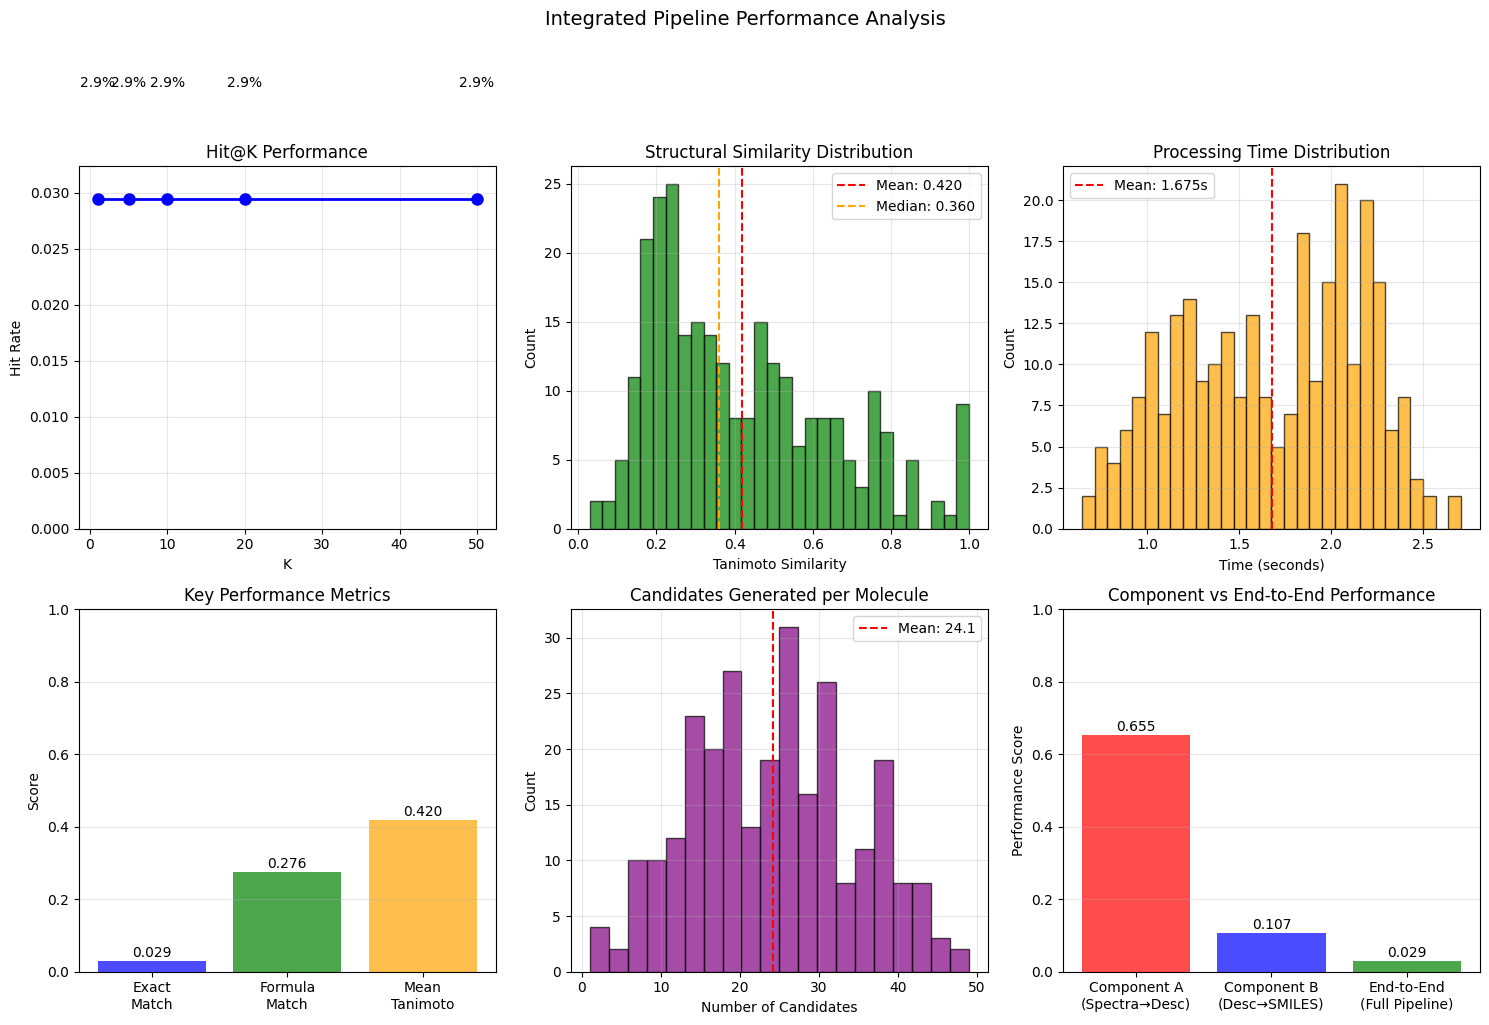


Figure saved to: ..\data\results\integration\hpj\pipeline_performance.png


In [9]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Hit@K curve
k_values = list(results['hit_at_k'].keys())
hit_rates = list(results['hit_at_k'].values())

axes[0, 0].plot(k_values, hit_rates, 'o-', linewidth=2, markersize=8, color='blue')
axes[0, 0].set_xlabel('K')
axes[0, 0].set_ylabel('Hit Rate')
axes[0, 0].set_title('Hit@K Performance')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, max(hit_rates) * 1.1])

for k, rate in zip(k_values, hit_rates):
    axes[0, 0].text(k, rate + 0.01, f'{rate:.1%}', ha='center')

# Tanimoto distribution
tanimoto_scores = results['raw_metrics']['tanimoto_scores']
if tanimoto_scores:
    axes[0, 1].hist(tanimoto_scores, bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[0, 1].axvline(np.mean(tanimoto_scores), color='red', linestyle='--',
                       label=f'Mean: {np.mean(tanimoto_scores):.3f}')
    axes[0, 1].axvline(np.median(tanimoto_scores), color='orange', linestyle='--',
                       label=f'Median: {np.median(tanimoto_scores):.3f}')
    axes[0, 1].set_xlabel('Tanimoto Similarity')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Structural Similarity Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# Processing time distribution
times = results['raw_metrics']['processing_times']
axes[0, 2].hist(times, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].axvline(np.mean(times), color='red', linestyle='--',
                   label=f'Mean: {np.mean(times):.3f}s')
axes[0, 2].set_xlabel('Time (seconds)')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Processing Time Distribution')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Performance metrics bar chart
metrics_names = ['Exact\nMatch', 'Formula\nMatch', 'Mean\nTanimoto']
metrics_values = [results['exact_match_rate'], results['formula_match_rate'], results['mean_tanimoto']]
colors = ['blue', 'green', 'orange']

bars = axes[1, 0].bar(metrics_names, metrics_values, color=colors, alpha=0.7)
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Key Performance Metrics')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, metrics_values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val:.3f}', ha='center')

# Candidates generated distribution
n_candidates = results['raw_metrics']['n_candidates']
axes[1, 1].hist(n_candidates, bins=20, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].axvline(np.mean(n_candidates), color='red', linestyle='--',
                   label=f'Mean: {np.mean(n_candidates):.1f}')
axes[1, 1].set_xlabel('Number of Candidates')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Candidates Generated per Molecule')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Component performance comparison
if part_a['test_metrics'] and part_b['results']:
    component_names = ['Component A\n(Spectra→Desc)', 'Component B\n(Desc→SMILES)', 'End-to-End\n(Full Pipeline)']
    component_scores = [
        np.mean([m['R2'] for m in part_a['test_metrics'].values()]),
        part_b['results'].get('exact_match_rate', 0),
        results['exact_match_rate']
    ]
    
    bars = axes[1, 2].bar(component_names, component_scores, color=['red', 'blue', 'green'], alpha=0.7)
    axes[1, 2].set_ylabel('Performance Score')
    axes[1, 2].set_title('Component vs End-to-End Performance')
    axes[1, 2].set_ylim([0, 1])
    axes[1, 2].grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, component_scores):
        axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{val:.3f}', ha='center')
else:
    axes[1, 2].axis('off')

plt.suptitle('Integrated Pipeline Performance Analysis', fontsize=14, y=1.02)
plt.tight_layout()

# Save figure
fig_path = results_dir / 'pipeline_performance.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {fig_path}")

## 8. Example Predictions

### Qualitative Analysis

In [10]:
print("\nExample Molecular Identifications:")
print("="*80)

n_examples = min(5, len(eval_data))
example_indices = np.random.choice(len(eval_data), n_examples, replace=False)

for i, idx in enumerate(example_indices):
    spectrum = eval_spectra[idx]
    true_smiles = eval_smiles[idx]
    
    # Run pipeline
    result = pipeline.predict(spectrum, n_candidates=20)
    
    # Compute ground truth properties
    true_mol = Chem.MolFromSmiles(true_smiles)
    true_mw = Descriptors.MolWt(true_mol)
    true_formula = Chem.rdMolDescriptors.CalcMolFormula(true_mol)
    
    print(f"\nExample {i+1}:")
    print(f"  Ground Truth:")
    print(f"    SMILES: {true_smiles}")
    print(f"    MW: {true_mw:.2f} Da")
    print(f"    Formula: {true_formula}")
    
    # Show predicted descriptors
    pred_desc = result['descriptors'][0]
    print(f"\n  Predicted Descriptors (selection):")
    print(f"    MW: {pred_desc[0]:.2f} Da (Error: {abs(pred_desc[0] - true_mw):.2f} Da)")
    print(f"    Heavy atoms: {pred_desc[1]:.1f}")
    print(f"    Heteroatoms: {pred_desc[2]:.1f}")
    
    # Show top candidates
    candidates = result['candidates']
    if candidates:
        ranked = pipeline.rank_candidates(candidates[:5], true_smiles)
        
        print(f"\n  Top 3 Generated Candidates:")
        for rank, (cand_smi, similarity) in enumerate(ranked[:3]):
            cand_mol = Chem.MolFromSmiles(cand_smi)
            if cand_mol:
                cand_formula = Chem.rdMolDescriptors.CalcMolFormula(cand_mol)
                match = "✓" if cand_smi == Chem.MolToSmiles(true_mol, canonical=True) else "✗"
                print(f"    {rank+1}. {cand_smi}")
                print(f"       Formula: {cand_formula}, Tanimoto: {similarity:.3f} {match}")
    else:
        print("  No candidates generated")
    
    print("-"*80)


Example Molecular Identifications:

Example 1:
  Ground Truth:
    SMILES: CC12CCC3C(C1CCC2(C)O)CCC4C3(CC5=C(C4)NN=C5)C
    MW: 328.50 Da
    Formula: C21H32N2O

  Predicted Descriptors (selection):
    MW: 332.64 Da (Error: 4.14 Da)
    Heavy atoms: 24.2
    Heteroatoms: 3.0

  Top 3 Generated Candidates:
    1. CCC(=O)OC1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C
       Formula: C22H32O3, Tanimoto: 0.208 ✗
    2. CC(CCC1CCCC2=CC(=O)CCC21C)C1CCC(C)(O)C(C)(C)O1
       Formula: C23H38O3, Tanimoto: 0.159 ✗
    3. CCC(=O)CC12CCC3C4CCC(=O)C=C4CCC3C1CCC2O
       Formula: C21H30O3, Tanimoto: 0.138 ✗
--------------------------------------------------------------------------------

Example 2:
  Ground Truth:
    SMILES: C1=CC=C2C(=C1)C(=NN2CCCCCF)C(=O)NC3=CC=CC4=C3N=CC=C4
    MW: 376.44 Da
    Formula: C22H21FN4O

  Predicted Descriptors (selection):
    MW: 375.60 Da (Error: 0.84 Da)
    Heavy atoms: 28.6
    Heteroatoms: 6.2

  Top 3 Generated Candidates:
    1. O=C(Oc1cccc2cccnc12)c1nn(CCCCCF)c2cccc

## 9. Results Export

### Data Persistence

In [11]:
if CONFIG['evaluation']['save_results']:
    # Prepare comprehensive results package
    results_package = {
        'config': CONFIG,
        'evaluation_results': results,
        'pipeline_components': {
            'component_a': {
                'model_type': 'LightGBM Ensemble',
                'n_models': len(part_a['models']),
                'descriptors': part_a['descriptor_names'],
                'preprocessing': part_a['preprocessing'],
                'performance': part_a.get('test_metrics', {})
            },
            'component_b': {
                'model_type': 'Conditional VAE',
                'vocab_size': len(part_b['vocab']),
                'model_config': part_b['model_config'],
                'performance': part_b.get('results', {})
            }
        },
        'dataset': CONFIG['dataset'],
        'timestamp': time.strftime('%Y%m%d_%H%M%S')
    }
    
    # Save full results
    pkl_path = results_dir / f"pipeline_results_{results_package['timestamp']}.pkl"
    with open(pkl_path, 'wb') as f:
        pickle.dump(results_package, f)
    
    print(f"\nResults package saved to: {pkl_path}")
    
    # Save summary JSON
    summary = {
        'dataset': CONFIG['dataset'],
        'pipeline': 'LightGBM + Conditional VAE',
        'performance': {
            'exact_match_rate': float(results['exact_match_rate']),
            'formula_match_rate': float(results['formula_match_rate']),
            'mean_tanimoto': float(results['mean_tanimoto']),
            'median_tanimoto': float(results['median_tanimoto']),
            'hit_at_k': {str(k): float(v) for k, v in results['hit_at_k'].items()}
        },
        'efficiency': {
            'avg_time_per_sample': float(results['avg_time_per_sample']),
            'throughput': float(1/results['avg_time_per_sample']),
            'n_samples': results['total_samples']
        },
        'timestamp': results_package['timestamp']
    }
    
    json_path = results_dir / f"pipeline_summary_{results_package['timestamp']}.json"
    with open(json_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"Summary saved to: {json_path}")


Results package saved to: ..\data\results\integration\hpj\pipeline_results_20250820_180900.pkl
Summary saved to: ..\data\results\integration\hpj\pipeline_summary_20250820_180900.json


## 10. Conclusions

### Pipeline Performance Summary

In [12]:
print("\n" + "="*70)
print("INTEGRATED PIPELINE SUMMARY")
print("="*70)

print("\nPipeline Architecture:")
print(f"  Dataset: {CONFIG['dataset']}")
print(f"  Component A: {len(part_a['models'])} LightGBM models")
print(f"  Component B: Conditional VAE (latent={part_b['model_config']['latent_dim']})")
print(f"  Input: Mass Spectrum ({part_a['spectrum_dim']} dimensions)")
print(f"  Intermediate: {len(part_a['descriptor_names'])} molecular descriptors")
print(f"  Output: {CONFIG['inference']['n_candidates']} SMILES candidates")

print("\nKey Performance Indicators:")
print(f"  • Exact molecular match: {results['exact_match_rate']:.1%}")
print(f"  • Formula accuracy: {results['formula_match_rate']:.1%}")
print(f"  • Structural similarity: {results['mean_tanimoto']:.3f} ± {results['std_tanimoto']:.3f}")
print(f"  • Top-10 retrieval: {results['hit_at_k'][10]:.1%}")
print(f"  • Processing speed: {1/results['avg_time_per_sample']:.1f} molecules/second")

print("\nPerformance Assessment:")
if results['exact_match_rate'] > 0.2:
    print("  ✓ Excellent exact match performance (>20%)")
elif results['exact_match_rate'] > 0.1:
    print("  ✓ Good exact match performance (10-20%)")
else:
    print("  ⚠ Moderate exact match performance (<10%)")

if results['mean_tanimoto'] > 0.7:
    print("  ✓ High structural similarity achieved (>0.7)")
elif results['mean_tanimoto'] > 0.5:
    print("  ✓ Good structural similarity achieved (0.5-0.7)")
else:
    print("  ⚠ Moderate structural similarity (<0.5)")

print("\nMethodological Insights:")
print("  • Gradient boosting provides efficient descriptor prediction")
print("  • Descriptor-specific models enable targeted optimization")
print("  • Conditional generation preserves chemical validity")
print("  • SELFIES representation ensures syntactic correctness")

print("\nFuture Directions:")
print("  1. Hyperparameter optimization for individual LightGBM models")
print("  2. Multi-modal fusion at the latent space level")
print("  3. Incorporation of spectral reconstruction loss")
print("  4. Active learning for targeted data acquisition")
print("  5. Ensemble methods for uncertainty quantification")

print("\n" + "="*70)
print("Pipeline evaluation successfully completed")
print("="*70)


INTEGRATED PIPELINE SUMMARY

Pipeline Architecture:
  Dataset: hpj
  Component A: 12 LightGBM models
  Component B: Conditional VAE (latent=128)
  Input: Mass Spectrum (500 dimensions)
  Intermediate: 12 molecular descriptors
  Output: 50 SMILES candidates

Key Performance Indicators:
  • Exact molecular match: 2.9%
  • Formula accuracy: 27.6%
  • Structural similarity: 0.420 ± 0.232
  • Top-10 retrieval: 2.9%
  • Processing speed: 0.6 molecules/second

Performance Assessment:
  ⚠ Moderate exact match performance (<10%)
  ⚠ Moderate structural similarity (<0.5)

Methodological Insights:
  • Gradient boosting provides efficient descriptor prediction
  • Descriptor-specific models enable targeted optimization
  • Conditional generation preserves chemical validity
  • SELFIES representation ensures syntactic correctness

Future Directions:
  1. Hyperparameter optimization for individual LightGBM models
  2. Multi-modal fusion at the latent space level
  3. Incorporation of spectral recon